In [26]:
from util.log import plot_ts_result
from util.process import MyDataset, Modeling
from util.model import TransformerModel, LSTM

import numpy as np
import pandas as pd

df = pd.read_csv("data/merged_fill.csv") 
df["INNER_HMDT"] = (df["INNER_HMDT_1"] + df["INNER_HMDT_2"]) / 2
df["INNER_TPRT"] = (df["INNER_TPRT_1"] + df["INNER_TPRT_2"]) / 2

x_cols = ["EXTN_TPRT", "INNER_HMDT"] #"DWP_TPRT"를 넣으면 Transformer에서 거의 100점짜리 답안이 나옴
y_cols = ["INNER_TPRT"]
data = MyDataset(df, x_cols, y_cols)
train_loader, test_loader = data.preprocessing(train_ratio=0.8)


In [28]:
modeling = Modeling(model=TransformerModel, 
                    data=data, lr=0.001)

modeling.train(
    epochs=100,
    train_loader=train_loader,
    test_loader=test_loader,
)

Using device: cuda
Epoch 10/100, Training Loss: 4.8300065994262695, Validation Loss: 6.00915368
Epoch 20/100, Training Loss: 6.252951145172119, Validation Loss: 6.45952947
Epoch 30/100, Training Loss: 7.078302383422852, Validation Loss: 6.46764135
Epoch 40/100, Training Loss: 4.825070858001709, Validation Loss: 6.36416416
Epoch 50/100, Training Loss: 5.035800933837891, Validation Loss: 6.56199705
Epoch 60/100, Training Loss: 5.025445461273193, Validation Loss: 6.06904628
Epoch 70/100, Training Loss: 6.875309467315674, Validation Loss: 7.10198396
Epoch 80/100, Training Loss: 4.643050193786621, Validation Loss: 7.19040810
Epoch 90/100, Training Loss: 3.313098430633545, Validation Loss: 5.99566160
Epoch 100/100, Training Loss: 4.662970542907715, Validation Loss: 6.84811221


In [32]:
true_val, pred_val = modeling.eval(train_loader, data.y_train)
batch_size = 32
X = df[x_cols][:len(train_loader)*batch_size]
y = df[y_cols][:len(train_loader)*batch_size]
X["pred"] = pred_val

explained_variance:  -1.03
r2:  -1.0744
MAE:  4.1488
MSE:  30.057
RMSE:  5.4824


In [72]:
# FAIL: RESIZE TICK 

import torch
import gym
from gym import spaces
import numpy as np

class GreenhouseTSEnv(gym.Env):
    def __init__(self, data, tick=0.5):
        super(GreenhouseTSEnv, self).__init__()
        self.tick = 0
        self.initial_tick = tick
        self.history = data
        self.current_step = -1
        batch_size, input_size = data[0].shape
        self.max_steps = batch_size-1

        self.observation_space = spaces.Box(
            low=-50, high=50, shape=(input_size,))
        # Action space: Up, Init, Hold, Down
        self.action_space = spaces.Discrete(4)
        
    def reset(self):
        self.tick = 0
        self.current_step = -1
        return self.history[0][self.current_step]

    def step(self, action):
        self.current_step += 1
        pred = self.history[0][self.current_step][-1]
        answer = self.history[1][self.current_step][-1]
        
        if action == 0:
            self.tick += self.initial_tick
        elif action == 1:
            self.tick = 0
        elif action == 2:
            pass
        else:
            self.tick -= self.initial_tick
        
        pred += self.tick
        reward = - abs(torch.tensor(pred) - answer)
        if reward <= -2:
            reward = 1

        observation = self.history[0][self.current_step]
        done = (self.current_step > self.max_steps) 
        if self.tick > 10 or reward < -100:
            done = True
            reward = -100

        return observation, reward, done, {}

    def step_infer(self, action):
        self.current_step += 1
        pred = self.history[0][self.current_step][-1]
        
        if action == 0:
            self.tick += self.initial_tick
        elif action == 1:
            self.tick = 0
        elif action == 2:
            pass
        else:
            self.tick -= self.initial_tick
        
        pred += self.tick
        # reward = - abs(torch.tensor(pred) - answer)
        observation = self.history[0][self.current_step]
        done = self.current_step > self.max_steps 
        return observation, None, done, {"new_pred": pred}

In [43]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network for Q-function approximation
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple(
            "Experience", field_names=["state", "action", "reward", "next_state", "done"]
        )

    def append(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states = torch.FloatTensor(np.array([e.state for e in batch])).to(DEVICE)  # GPU로 이동
        actions = torch.LongTensor(np.array([e.action for e in batch])).to(DEVICE)  # GPU로 이동
        rewards = torch.FloatTensor(np.array([e.reward for e in batch])).to(DEVICE)  # GPU로 이동
        next_states = torch.FloatTensor(np.array([e.next_state for e in batch])).to(DEVICE)  # GPU로 이동
        dones = torch.BoolTensor(np.array([e.done for e in batch])).to(DEVICE)  # GPU로 이동
        return states, actions, rewards, next_states, dones

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size=int(1e5), batch_size=32, gamma=0.99, lr=1e-3, update_freq=4, target_update_freq=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.update_freq = update_freq
        self.target_update_freq = target_update_freq
        self.q_network = DQN(state_size, action_size).to(DEVICE)  # GPU로 이동
        self.target_network = DQN(state_size, action_size).to(DEVICE)  # GPU로 이동
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.steps = 0

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)  # GPU로 이동
            q_values = self.q_network(state)
            return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.append(state, action, reward, next_state, done)

    def train(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + (1 - dones.float()) * self.gamma * next_q_values
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

Episode: 50, Reward: 0.4944291007041938, Epsilon: 0.9512056281970315
Episode: 100, Reward: 0.5214848654746974, Epsilon: 0.9047921471137096
Episode: 150, Reward: 0.4926445084571843, Epsilon: 0.8606433826830369
Episode: 200, Reward: 0.532455581092828, Epsilon: 0.818648829478636
Episode: 250, Reward: 0.5358453622817941, Epsilon: 0.7787033741169904
Episode: 300, Reward: 0.537535998821251, Epsilon: 0.7407070321560997
Episode: 350, Reward: 0.5182133700370751, Epsilon: 0.704564697832001
Episode: 400, Reward: 0.5288480471610968, Epsilon: 0.6701859060067403
Episode: 450, Reward: 0.5307107164382866, Epsilon: 0.6374846057319378
Episode: 500, Reward: 0.5046068526268007, Epsilon: 0.6063789448611848
Episode: 550, Reward: 0.5214402387618978, Epsilon: 0.5767910651721362
Episode: 600, Reward: 0.5814269908904912, Epsilon: 0.5486469074854965
Episode: 650, Reward: 0.5468451122283855, Epsilon: 0.5218760262931003
Episode: 700, Reward: 0.5510150448799056, Epsilon: 0.4964114134310989
Episode: 750, Reward: 0.5

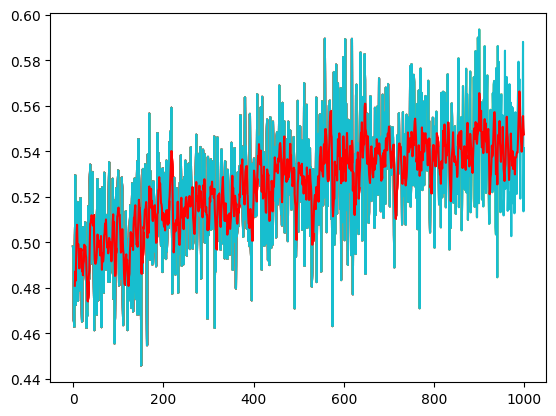

In [44]:
# with GPU: 22 min
window_size = 2000
env = GreenhouseTSEnv([
    X.iloc[:window_size].to_numpy(),
    y.iloc[:window_size].to_numpy(),
])

state_size = env.observation_space.shape[-1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 0.999
max_episodes = 1000
max_steps_per_episode = env.max_steps
moving_average_window = 5

import matplotlib.pyplot as plt
episode_rewards = []
epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, info = env.step(action)

        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_exp.png")


Episode: 50, Reward: 0.6086931684493871, Epsilon: 0.349753957504439
Episode: 100, Reward: 0.5799322618484379, Epsilon: 0.33268793286240766
Episode: 150, Reward: 0.5294216558456366, Epsilon: 0.31645463417195824
Episode: 200, Reward: 0.5709371460914494, Epsilon: 0.3010134290933992
Episode: 250, Reward: 0.563799956321707, Epsilon: 0.28632566791652947
Episode: 300, Reward: 0.5333287406921333, Epsilon: 0.27235458681947705
Episode: 350, Reward: 0.5435029661178502, Epsilon: 0.25906521584796366
Episode: 400, Reward: 0.5955129835128653, Epsilon: 0.24642429138466176
Episode: 450, Reward: 0.6076684520721275, Epsilon: 0.23440017288955545
Episode: 500, Reward: 0.6029767457961877, Epsilon: 0.22296276370290227
Episode: 550, Reward: 0.5893899806022517, Epsilon: 0.21208343571256533
Episode: 600, Reward: 0.5807987004279953, Epsilon: 0.20173495769715546
Episode: 650, Reward: 0.5906562037467818, Epsilon: 0.19189142716562432
Episode: 700, Reward: 0.544755435562126, Epsilon: 0.18252820552270246
Episode: 750

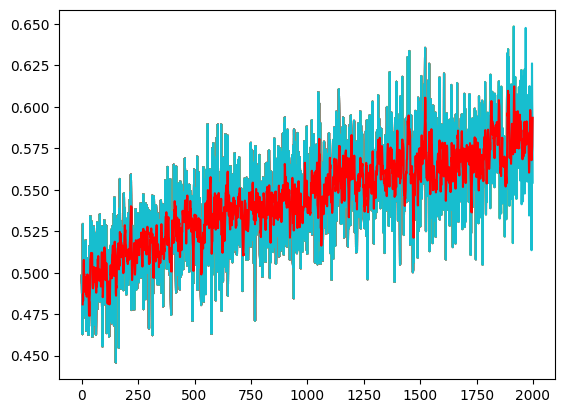

In [45]:
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, info = env.step(action)

        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_exp.png")

In [46]:
torch.save(agent.q_network, 'tick_q_model.pth')
torch.save(agent.target_network, 'tick_target_model.pth')


Episode: 50, Reward: 0.5464125655174176, Epsilon: 0.12860292996992018
Episode: 100, Reward: 0.5742917221069234, Epsilon: 0.12232783079001676
Episode: 150, Reward: 0.5704401732444664, Epsilon: 0.11635892113259806
Episode: 200, Reward: 0.5899418856620657, Epsilon: 0.11068126067226178
Episode: 250, Reward: 0.5731491101264844, Epsilon: 0.10528063808739813
Episode: 300, Reward: 0.6018552178382737, Epsilon: 0.10014353548890782
Episode: 350, Reward: 0.6230154386520207, Epsilon: 0.09525709458459826
Episode: 400, Reward: 0.538273603057854, Epsilon: 0.09060908449456685
Episode: 450, Reward: 0.5957639090537894, Epsilon: 0.08618787113701235
Episode: 500, Reward: 0.5951381505966032, Epsilon: 0.08198238810784661
Episode: 550, Reward: 0.6238311309814295, Epsilon: 0.07798210898121705
Episode: 600, Reward: 0.6021712607383594, Epsilon: 0.07417702096160789
Episode: 650, Reward: 0.5869068320274237, Epsilon: 0.0705575998215706
Episode: 700, Reward: 0.5426206486701904, Epsilon: 0.06711478606235186
Episode: 

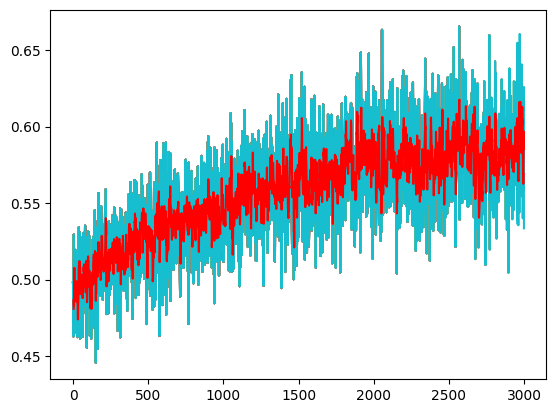

In [47]:
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, info = env.step(action)

        reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_exp.png")

In [ ]:
# for episode in range(1, max_episodes + 1):
#     state = env.reset()
#     episode_reward = 0
#     for step in range(max_steps_per_episode):
#         action = agent.select_action(state, epsilon)
#         next_state, reward, done, info = env.step(action)

#         reward = -np.exp(reward/window_size)
#         agent.store_experience(state, action, reward, next_state, done)
#         agent.train()
#         state = next_state
#         episode_reward += reward
#         if done:
#             break
#     epsilon = max(epsilon_final, epsilon * epsilon_decay)
#     episode_rewards.append(episode_reward)
#     if episode % 50 == 0:
#       print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
#       plt.plot(episode_rewards)
#       moving_average = np.convolve(
#           episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
#       plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
#                moving_average, label=f'{moving_average_window}-Times Moving Average', 
#                color='red')
#       plt.savefig("rewards_exp2.png")

KeyboardInterrupt: 

explained_variance:  0.7382
r2:  0.7258
MAE:  2.0696
MSE:  6.8481
RMSE:  2.6169


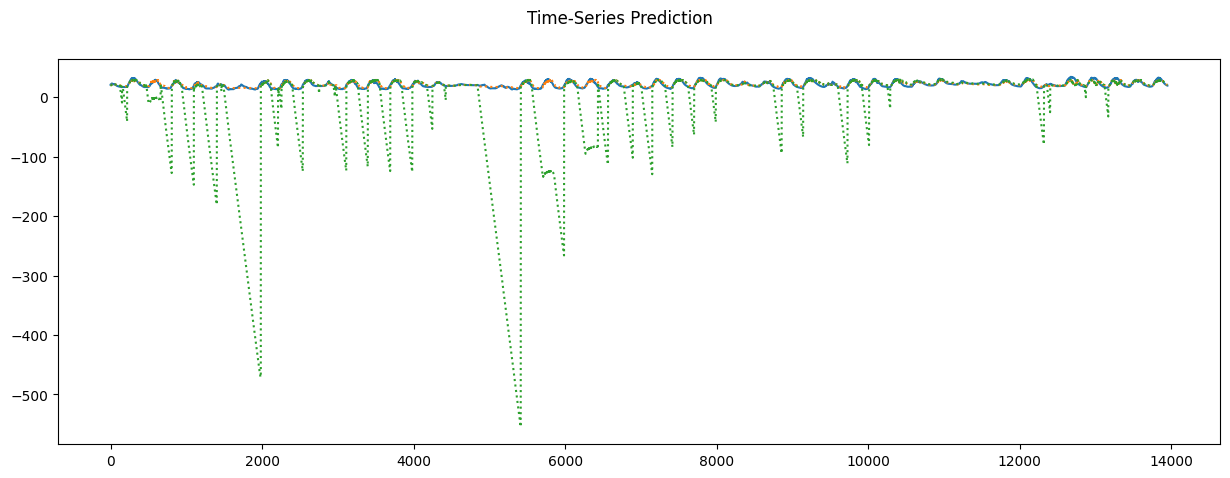

explained_variance:  0.7382
r2:  0.7258
MAE:  2.0697
MSE:  6.8485
RMSE:  2.617
explained_variance:  -315.1075
r2:  -375.477
MAE:  40.4692
MSE:  9401.5122
RMSE:  96.9614


In [48]:
from util.log import regression_results

true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
max_steps_per_episode = new_batch = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step_infer(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    # episode_reward += reward
    
    if done:
        break
plot_ts_result(true_val[:new_batch], pred_val[:new_batch],new_pred_val)

# 개선 전
regression_results(true_val[:new_batch], pred_val[:new_batch])
# 개선 후
regression_results(true_val[:new_batch], new_pred_val)

Episode: 50, Reward: 123.78346183776864, Epsilon: 0.9512056281970315
Episode: 100, Reward: 234.92463287353527, Epsilon: 0.9047921471137096
Episode: 150, Reward: 219.51635471344022, Epsilon: 0.8606433826830369
Episode: 200, Reward: 387.0431631851203, Epsilon: 0.818648829478636
Episode: 250, Reward: 466.8841992187501, Epsilon: 0.7787033741169904
Episode: 300, Reward: 633.2903061294556, Epsilon: 0.7407070321560997
Episode: 350, Reward: 656.3253465652471, Epsilon: 0.704564697832001
Episode: 400, Reward: 855.7783550643925, Epsilon: 0.6701859060067403
Episode: 450, Reward: 723.4611545562748, Epsilon: 0.6374846057319378
Episode: 500, Reward: 735.8355562591543, Epsilon: 0.6063789448611848
Episode: 550, Reward: 884.0907088088986, Epsilon: 0.5767910651721362
Episode: 600, Reward: 865.1947438812257, Epsilon: 0.5486469074854965
Episode: 650, Reward: 582.8369361877444, Epsilon: 0.5218760262931003
Episode: 700, Reward: 888.1670182800286, Epsilon: 0.4964114134310989
Episode: 750, Reward: 1003.8470363

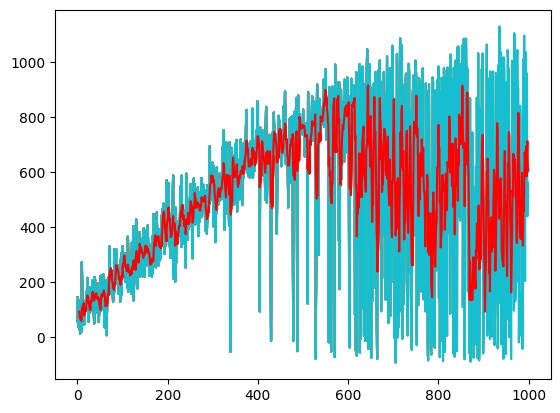

In [64]:
# with GPU: 22 min
window_size = 2000
env = GreenhouseTSEnv([
    X.iloc[:window_size].to_numpy(),
    y.iloc[:window_size].to_numpy(),
])

state_size = env.observation_space.shape[-1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.08
epsilon_decay = 0.999
max_episodes = 1000
max_steps_per_episode = env.max_steps
moving_average_window = 5

import matplotlib.pyplot as plt
episode_rewards = []
epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, info = env.step(action)

        # reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_tick_explore.png")


explained_variance:  0.7382
r2:  0.7258
MAE:  2.0696
MSE:  6.8481
RMSE:  2.6169


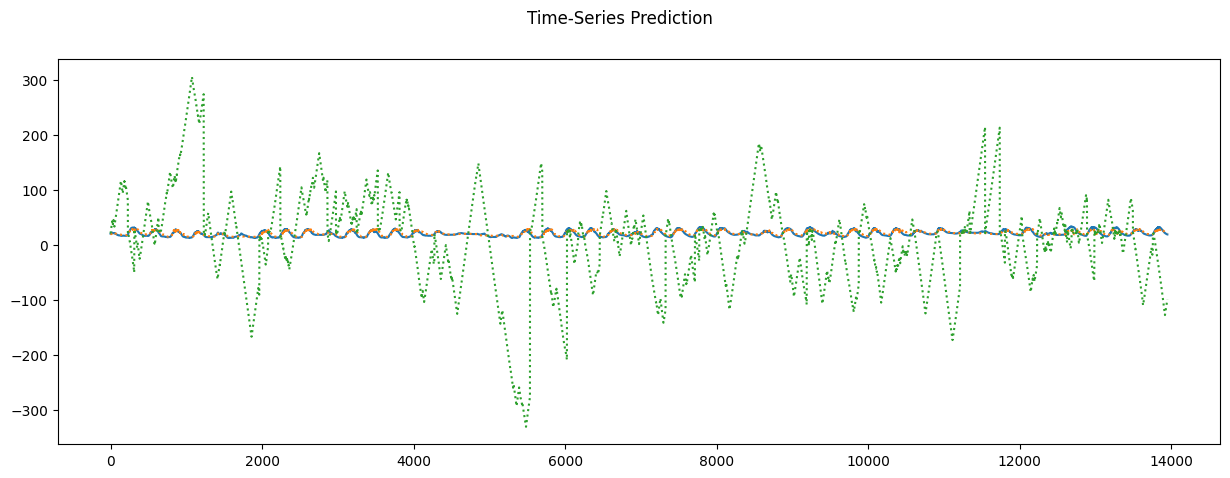

explained_variance:  0.7382
r2:  0.7258
MAE:  2.0697
MSE:  6.8485
RMSE:  2.617
explained_variance:  -315.7144
r2:  -325.0431
MAE:  66.7179
MSE:  8142.0583
RMSE:  90.2334


In [65]:
from util.log import regression_results

true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
max_steps_per_episode = new_batch = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step_infer(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    
    state = next_state
    # episode_reward += reward
    
    if done:
        break
plot_ts_result(true_val[:new_batch], pred_val[:new_batch],new_pred_val)

# 개선 전
regression_results(true_val[:new_batch], pred_val[:new_batch])
# 개선 후
regression_results(true_val[:new_batch], new_pred_val)

Episode: 50, Reward: 1.7961692810058025, Epsilon: 0.9512056281970315
Episode: 100, Reward: 42.895861549377564, Epsilon: 0.9047921471137096
Episode: 150, Reward: 208.11654228210466, Epsilon: 0.8606433826830369
Episode: 200, Reward: 133.36172817230207, Epsilon: 0.818648829478636
Episode: 250, Reward: 182.99209781646732, Epsilon: 0.7787033741169904
Episode: 300, Reward: 239.15587207794195, Epsilon: 0.7407070321560997
Episode: 350, Reward: 406.85506381988597, Epsilon: 0.704564697832001
Episode: 400, Reward: 301.89574623107876, Epsilon: 0.6701859060067403
Episode: 450, Reward: 356.60780105590845, Epsilon: 0.6374846057319378
Episode: 500, Reward: 587.1660231399537, Epsilon: 0.6063789448611848


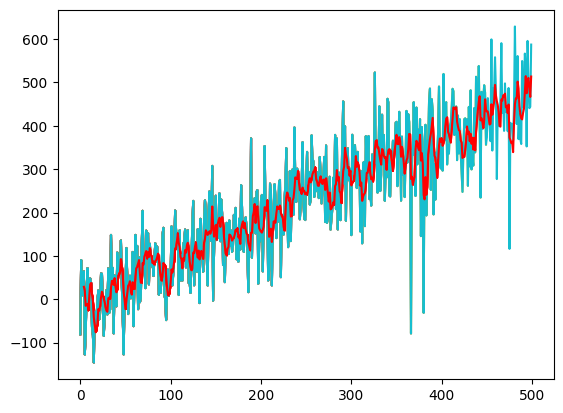

In [80]:
# with GPU: 22 min
window_size = 2000
env = GreenhouseTSEnv([
    X.iloc[:window_size].to_numpy(),
    y.iloc[:window_size].to_numpy(),
])

state_size = env.observation_space.shape[-1]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.08
epsilon_decay = 0.999
max_episodes = 500
max_steps_per_episode = env.max_steps
moving_average_window = 5

import matplotlib.pyplot as plt
episode_rewards = []
epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, info = env.step(action)

        # reward = reward/window_size
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward.item()}, Epsilon: {epsilon}")
      plt.plot(episode_rewards)
      moving_average = np.convolve(
          episode_rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
      plt.plot(np.arange(moving_average_window-1, len(episode_rewards)), 
               moving_average, label=f'{moving_average_window}-Times Moving Average', 
               color='red')
      plt.savefig("rewards_tick_explore.png")


explained_variance:  0.7382
r2:  0.7258
MAE:  2.0696
MSE:  6.8481
RMSE:  2.6169
explained_variance:  -3396.8206
r2:  -4557.1301
MAE:  241.4153
MSE:  113827.1669
RMSE:  337.3828


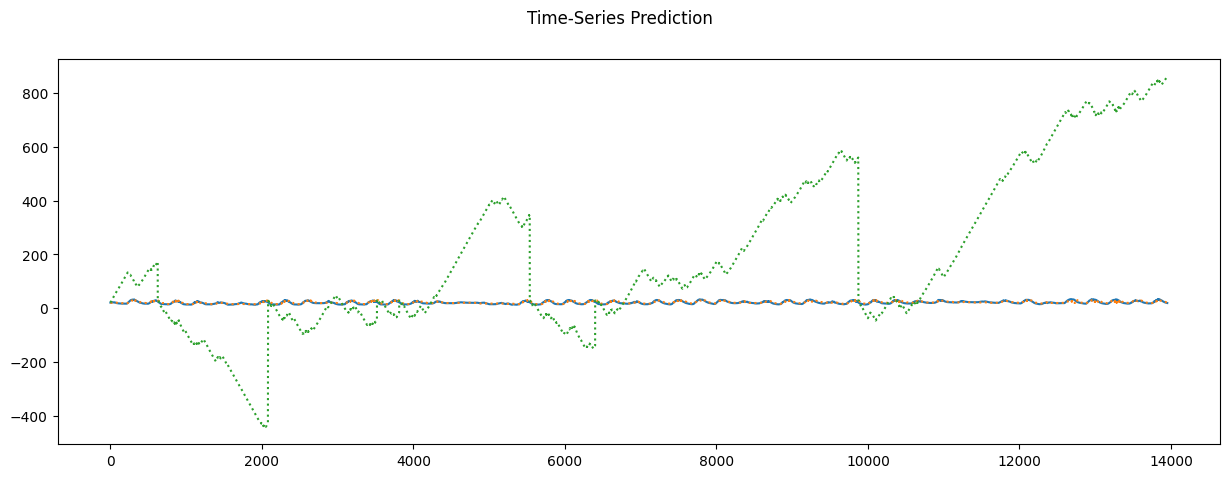

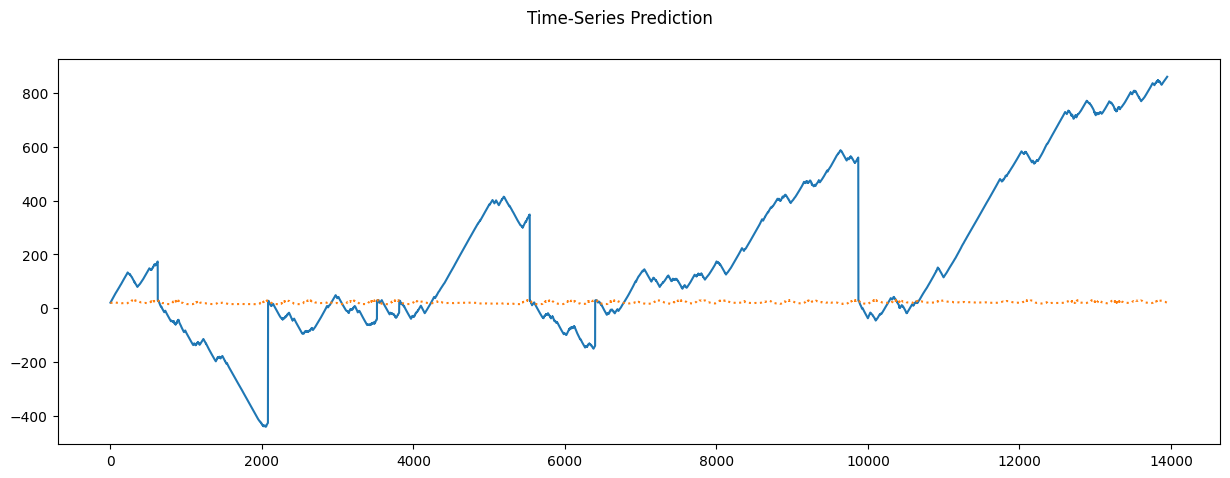

In [81]:
true_val, pred_val = modeling.eval(test_loader, data.y_test)
batch_size = 32
X = df[x_cols][-len(test_loader)*batch_size:]
y = df[y_cols][-len(test_loader)*batch_size:]
X["pred"] = pred_val

env = GreenhouseTSEnv([
    X.to_numpy(), y.to_numpy()
])
new_batch = X.shape[0]
max_steps_per_episode = env.max_steps


new_pred_val = []
epsilon = 0.0  # 추론할 때는 무작위 탐험이 필요하지 않으므로 epsilon을 0으로 설정

state = env.reset()
episode_reward = 0

for step in range(max_steps_per_episode):
    action = agent.select_action(state, epsilon)
    next_state, reward, done, info = env.step_infer(action)
    new_pred_val.append(info["new_pred"])  # 새로운 예측값을 저장
    state = next_state
    
    if done:
        break
# 개선 후
regression_results(true_val[:max_steps_per_episode], new_pred_val)

plot_ts_result(true_val, pred_val,new_pred_val)
plot_ts_result(new_pred_val, pred_val)